In [1]:
!pip install -q feature_engine 2>/dev/null

In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
!pip install catboost
import seaborn as sns
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import ast

pd.set_option('display.max_rows', 1000)


In [3]:
# Load the datasets
df_2022 = pd.read_csv('survey_results_public2022.csv').drop(['ResponseId'], axis=1).drop_duplicates()
df_2023 = pd.read_csv('survey_results_public2023.csv').drop(['ResponseId'], axis=1).drop_duplicates()
df_2024 = pd.read_csv('survey_results_public2024.csv').drop(['ResponseId'], axis=1).drop_duplicates()

#Add columns for specific years
df_2022['Year'] = 2022
df_2023['Year'] = 2023
df_2024['Year'] = 2024

In [4]:
# Rename AIAcc to AIBen and AIBen to AIAcc
df_2023 = df_2023.rename(columns={'AIAcc': 'Temp', 'AIBen': 'AIAcc'})
df_2023 = df_2023.rename(columns={'Temp': 'AIBen'})

In [5]:
# Add AIThreat and AIChallenge column to 2023
df_2023['AIThreat'] = np.nan
df_2023['AIChallenge'] = np.nan

In [6]:
# Rename specific columns
df_2024 = df_2024.rename(columns={
    'AINextMuch less integrated': 'AINextVery different',
    'AINextLess integrated': 'AINextSomewhat different',
    'AINextMore integrated': 'AINextSomewhat similar',
    'AINextMuch more integrated': 'AINextVery similar',
    'AINextNo change': 'AINextNeither different nor similar'

})

In [7]:
# Merge AIDevHaveWorkedWith and AISearchHaveWorkedWith to AISearchDevHaveWorkedWith
df_2023['AISearchDevHaveWorkedWith'] = df_2023['AIDevHaveWorkedWith'].astype(str) + ";" + df_2023['AISearchHaveWorkedWith'].astype(str)
df_2023['AISearchDevWantToWorkWith'] = df_2023['AIDevWantToWorkWith'].astype(str) + ";" + df_2023['AISearchWantToWorkWith'].astype(str)


In [8]:
# Merge the datasets
data = pd.concat([df_2022, df_2023, df_2024])

In [9]:
# Categorize columns
# Demographics
demographics_columns = [
    "MainBranch",
    "Age",
    "Country",
    "EdLevel"
]


# Tech Stack
tech_stack = [
    "LanguageHaveWorkedWith",
    "LanguageWantToWorkWith",
    "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith",
    "PlatformHaveWorkedWith",
    "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith",
    "WebframeWantToWorkWith",
    "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith",
    "ToolsTechHaveWorkedWith",
    "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith",
    "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use",
    "OpSysProfessional use",
    "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith",
    "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith"
]

# Employment
employment_information = [
    "Employment",
    "OrgSize",
    "WorkExp",
    "Industry",
    "ConvertedCompYearly",
    "YearsCode",
    "YearsCodePro",
    "DevType",
    "RemoteWork"
]

ai_stack= [
   "AISearchDevHaveWorkedWith",
   "AISearchDevWantToWorkWith",
    "AISelect",
    "AISent",
    "AIAcc",
    "AIBen",
    "AIToolInterested in Using",
    "AIToolCurrently Using",
    "AIToolNot interested in Using",
    "AINextVery different",
    "AINextNeither different nor similar",
    "AINextSomewhat similar",
    "AINextVery similar",
    "AINextSomewhat different"

]

# Community Engagement
community_engagement = [
    "SOVisitFreq",
    "SOAccount",
    "SOPartFreq",
    "SOComm",
    "NEWSOSites"
]

In [12]:
# combine 2022, 2023 and 2024 year datasets using only relevant common columns for salary preduiction
salary_pred_cols = [
    "Employment",
    "OrgSize",
    "WorkExp",
    "ConvertedCompYearly",
    "YearsCode",
    "YearsCodePro",
    "DevType",
    "RemoteWork",
    "MainBranch",
    "Age",
    "Country",
    "EdLevel",
    "LanguageHaveWorkedWith",
    "LanguageWantToWorkWith",
    "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith",
    "PlatformHaveWorkedWith",
    "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith",
    "WebframeWantToWorkWith",
    "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith",
    "ToolsTechHaveWorkedWith",
    "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith",
    "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use",
    "OpSysProfessional use",
    "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith",
    "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith",
]
df_salary_pred  = pd.concat([df_2022[salary_pred_cols], df_2023[salary_pred_cols], df_2024[salary_pred_cols]], axis=0)
print(df_salary_pred.shape)

(224703, 32)


In [13]:
# select main label
main_label = 'ConvertedCompYearly'
# Convert compensations into kUSD/year
df_salary_pred[main_label] = df_salary_pred[main_label]*1e-3
# select records with main label more than 1kUSD/year
df_salary_pred = df_salary_pred[df_salary_pred[main_label]>1.0]
# further exclude 2% of smallest and 2% of highest salaries
P = np.percentile(df_salary_pred[main_label], [2, 98])
df_salary_pred = df_salary_pred[(df_salary_pred[main_label] > P[0]) & (df_salary_pred[main_label] < P[1])]

print(df_salary_pred.shape)

(103629, 32)


In [14]:
# convert YearsCode, YearsCodePro, and WorkExp to integers
def clean_age(x):
    if x == 'Less than 1 year':
        return 0
    elif x == 'More than 50 years':
        return 51
    else:
        return x
df_salary_pred['YearsCode'] = df_salary_pred['YearsCode'].apply(clean_age).fillna(-1).astype(int)
df_salary_pred['YearsCodePro'] = df_salary_pred['YearsCodePro'].apply(clean_age).fillna(-1).astype(int)
df_salary_pred['WorkExp'] = df_salary_pred['WorkExp'].fillna(-1).astype(int)


In [20]:
# set up the rare label encoder limiting number of categories to max_n_categories
encoded_cols = [
    "Employment",
    "OrgSize",
    "DevType",
    "RemoteWork",
    "MainBranch",
    "Age",
    "Country",
    "EdLevel",
    "LanguageHaveWorkedWith",
    "LanguageWantToWorkWith",
    "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith",
    "PlatformHaveWorkedWith",
    "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith",
    "WebframeWantToWorkWith",
    "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith",
    "ToolsTechHaveWorkedWith",
    "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith",
    "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use",
    "OpSysProfessional use",
    "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith",
    "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith"]

df_salary_pred[encoded_cols] = df_salary_pred[encoded_cols].fillna('Missing')

# df_salary_pred['Employment'] = df_salary_pred['Employment'].fillna('Missing')
# df_salary_pred['OrgSize'] = df_salary_pred['OrgSize'].fillna('Missing')
# df_salary_pred['DevType'] = df_salary_pred['DevType'].fillna('Missing')
# df_salary_pred['RemoteWork'] = df_salary_pred['RemoteWork'].fillna('Missing')
# df_salary_pred['LanguageHaveWorkedWith'] = df_salary_pred['LanguageHaveWorkedWith'].fillna('Missing')
# df_salary_pred['LanguageWantToWorkWith'] = df_salary_pred['LanguageWantToWorkWith'].fillna('Missing')
# df_salary_pred['DatabaseHaveWorkedWith'] = df_salary_pred['DatabaseHaveWorkedWith'].fillna('Missing')
# df_salary_pred['DatabaseWantToWorkWith'] = df_salary_pred['DatabaseWantToWorkWith'].fillna('Missing')
# df_salary_pred['PlatformHaveWorkedWith'] = df_salary_pred['PlatformHaveWorkedWith'].fillna('Missing')
# df_salary_pred['PlatformWantToWorkWith'] = df_salary_pred['PlatformWantToWorkWith'].fillna('Missing')
# df_salary_pred['WebframeHaveWorkedWith'] = df_salary_pred['WebframeHaveWorkedWith'].fillna('Missing')
# df_salary_pred['WebframeWantToWorkWith'] = df_salary_pred['WebframeWantToWorkWith'].fillna('Missing')
# df_salary_pred['MiscTechHaveWorkedWith'] = df_salary_pred['MiscTechHaveWorkedWith'].fillna('Missing')
# df_salary_pred['MiscTechWantToWorkWith'] = df_salary_pred['MiscTechWantToWorkWith'].fillna('Missing')
# df_salary_pred['NEWCollabToolsHaveWorkedWith'] = df_salary_pred['NEWCollabToolsHaveWorkedWith'].fillna('Missing')
# df_salary_pred['NEWCollabToolsWantToWorkWith'] = df_salary_pred['NEWCollabToolsWantToWorkWith'].fillna('Missing')
# df_salary_pred['OfficeStackAsyncHaveWorkedWith'] = df_salary_pred['OfficeStackSyncHaveWorkedWith'].fillna('Missing')
# df_salary_pred['OfficeStackAsyncWantToWorkWith'] = df_salary_pred['OfficeStackAsyncWantToWorkWith'].fillna('Missing')
# df_salary_pred['OfficeStackSyncHaveWorkedWith'] = df_salary_pred['OfficeStackSyncHaveWorkedWith'].fillna('Missing')
# df_salary_pred['OfficeStackSyncWantToWorkWith'] = df_salary_pred['OfficeStackSyncWantToWorkWith'].fillna('Missing')
# df_salary_pred['OpSysPersonal use'] = df_salary_pred['OpSysPersonal use'].fillna('Missing')
# df_salary_pred['OpSysProfessional use'] = df_salary_pred['OpSysProfessional use'].fillna('Missing')
# df_salary_pred['ToolsTechHaveWorkedWith'] = df_salary_pred['ToolsTechHaveWorkedWith'].fillna('Missing')
# df_salary_pred['ToolsTechWantToWorkWith'] = df_salary_pred['ToolsTechWantToWorkWith'].fillna('Missing')


for col in encoded_cols:
    print("Rare encode column", col)
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=100, replace_with='Other', tol=20/df_salary_pred.shape[0])
    df_salary_pred[col] = encoder.fit_transform(df_salary_pred[[col]])

Rare encode column Employment
Rare encode column OrgSize
Rare encode column DevType
Rare encode column RemoteWork
Rare encode column MainBranch
Rare encode column Age
Rare encode column Country
Rare encode column EdLevel
Rare encode column LanguageHaveWorkedWith
Rare encode column LanguageWantToWorkWith
Rare encode column DatabaseHaveWorkedWith
Rare encode column DatabaseWantToWorkWith
Rare encode column PlatformHaveWorkedWith
Rare encode column PlatformWantToWorkWith
Rare encode column WebframeHaveWorkedWith
Rare encode column WebframeWantToWorkWith
Rare encode column MiscTechHaveWorkedWith
Rare encode column MiscTechWantToWorkWith
Rare encode column ToolsTechHaveWorkedWith
Rare encode column ToolsTechWantToWorkWith
Rare encode column NEWCollabToolsHaveWorkedWith
Rare encode column NEWCollabToolsWantToWorkWith
Rare encode column OpSysPersonal use
Rare encode column OpSysProfessional use
Rare encode column OfficeStackAsyncHaveWorkedWith
Rare encode column OfficeStackAsyncWantToWorkWith

In [21]:
# initialize data
y = df_salary_pred[main_label].values.reshape(-1,)
X = df_salary_pred.drop([main_label], axis=1)
cat_cols = df_salary_pred.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((51814, 31), (51815, 31), (51814,), (51815,))

In [22]:
%%time
# initialize Pool
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostRegressor(iterations=1000, # Number of boosting iteration
                          depth=10, # Maximum depth of trees in the ensemble
                          verbose=0, # Set verbosity level to 0 (no output during training)
                          early_stopping_rounds=100, # Early stopping rounds
                          learning_rate=0.02, # Learning rate for gradient boosting
                          loss_function='RMSE')
# train the model
model.fit(train_pool, eval_set=test_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} kUSD/year, and for test {round(rmse_test,2)} kUSD/year")

RMSE score for train 40.99 kUSD/year, and for test 43.69 kUSD/year
CPU times: user 30min 35s, sys: 10.4 s, total: 30min 46s
Wall time: 20min 6s


In [25]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,1)} kUSD/year, and for test {round(rmse_bs_test,1)} kUSD/year")

RMSE baseline score for train 67.4 kUSD/year, and for test 67.4 kUSD/year


In [26]:
import pandas as pd

# Example data for higher salary prediction
new_data = pd.DataFrame({
    'Employment': ['Employed full-time'],  # Full-time employment
    'OrgSize': ['10,000 or more employees'],  # Large organization size
    'WorkExp': [15],  # Extensive work experience
    'YearsCode': [20],  # Significant coding experience
    'YearsCodePro': [15],  # Long professional coding experience
    'DevType': ['Machine Learning Specialist'],  # High-demand developer type
    'RemoteWork': ['Fully remote'],  # Fully remote
    'MainBranch': ['I am a developer by profession'],  # Professional developer
    'Age': [40],  # Experienced age bracket
    'Country': ['United States'],  # High-paying country
    'EdLevel': ["Doctoral degree"],  # Advanced education level
    'LanguageHaveWorkedWith': ['Python;C++;R'],  # High-demand programming languages
    'LanguageWantToWorkWith': ['Rust;Julia'],  # Niche, high-demand languages
    'DatabaseHaveWorkedWith': ['PostgreSQL;MongoDB'],  # Advanced databases
    'DatabaseWantToWorkWith': ['Neo4j'],  # Cutting-edge databases
    'PlatformHaveWorkedWith': ['AWS;Google Cloud Platform'],  # Cloud platforms
    'PlatformWantToWorkWith': ['Azure'],  # Interest in enterprise platforms
    'WebframeHaveWorkedWith': ['TensorFlow;PyTorch'],  # Specialized frameworks
    'WebframeWantToWorkWith': ['Hugging Face'],  # AI/ML framework
    'MiscTechHaveWorkedWith': ['Kubernetes;Terraform'],  # Infrastructure as code
    'MiscTechWantToWorkWith': ['Ansible'],  # Desired cutting-edge tools
    'ToolsTechHaveWorkedWith': ['VSCode;Jupyter'],  # Common developer tools
    'ToolsTechWantToWorkWith': ['JetBrains'],  # High-end tools
    'NEWCollabToolsHaveWorkedWith': ['Slack;Teams'],  # Collaboration tools
    'NEWCollabToolsWantToWorkWith': ['Zoom'],  # Desired collaboration tools
    'OpSysPersonal use': ['Linux'],  # Preferred operating system
    'OpSysProfessional use': ['Linux'],  # Professional operating system
    'OfficeStackAsyncHaveWorkedWith': ['Notion;Google Docs'],  # Async tools
    'OfficeStackAsyncWantToWorkWith': ['Evernote'],  # Desired async tools
    'OfficeStackSyncHaveWorkedWith': ['Microsoft Office'],  # Sync tools
    'OfficeStackSyncWantToWorkWith': ['Google Workspace']  # Desired sync tools
})

# Ensure data types are consistent with training data
for col in new_data.columns:
    new_data[col] = new_data[col].astype(str)

# Make prediction
y_pred = model.predict(new_data)
print(f"Predicted salary: {round(y_pred[0], 2)} kUSD/year")

Predicted salary: 85.42 kUSD/year


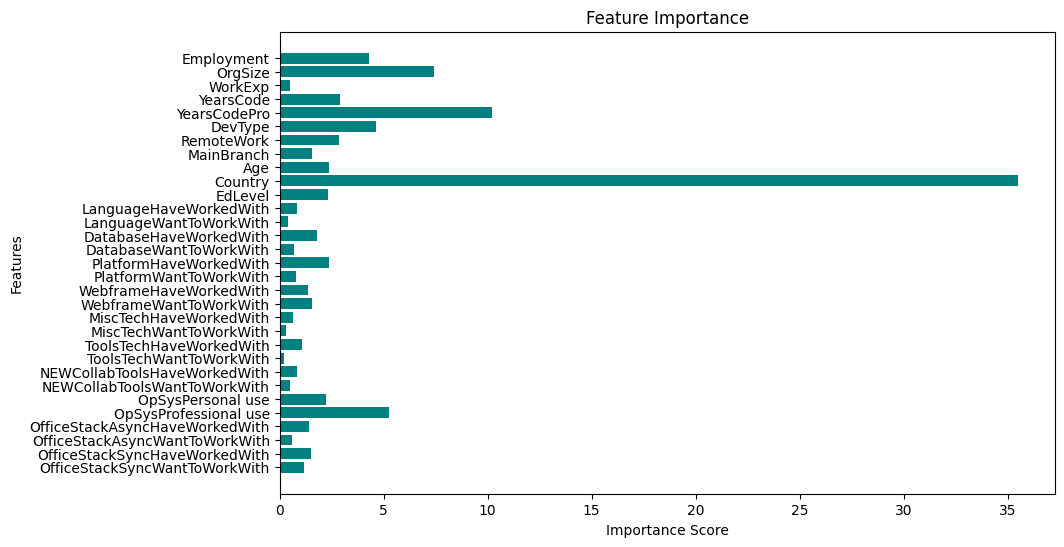

In [28]:
# Plot feature importance
feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color="teal")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


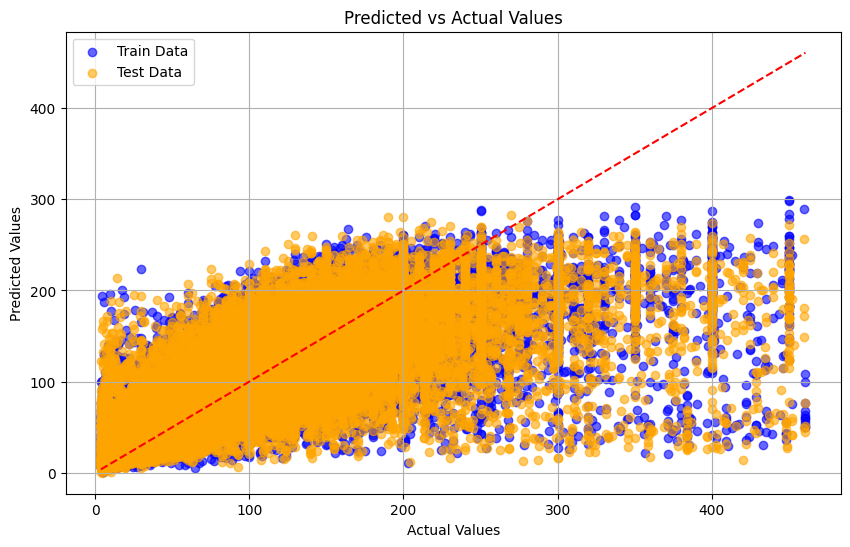

In [29]:
# Scatter plot for train data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, color="blue", label="Train Data")
plt.scatter(y_test, y_test_pred, alpha=0.6, color="orange", label="Test Data")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="red", linestyle="--")
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


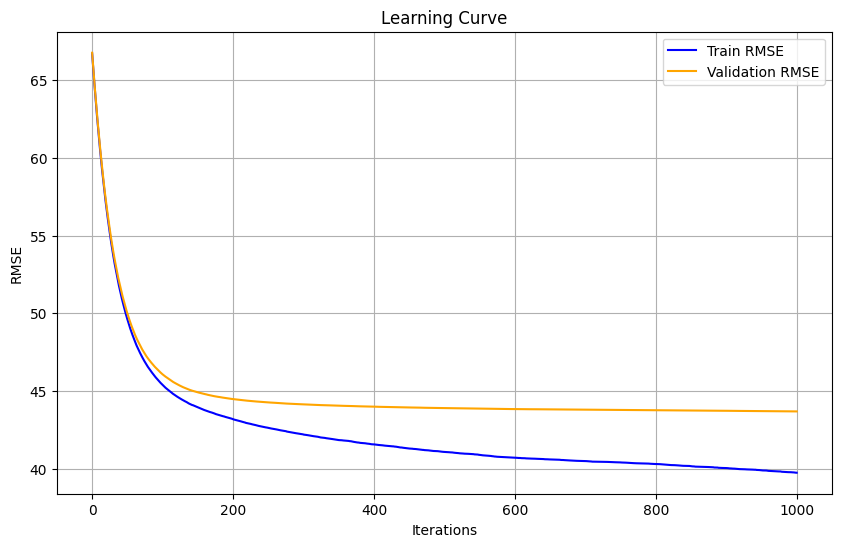

In [30]:
# Extract learning curve metrics
learning_curve = model.get_evals_result()
train_rmse = learning_curve['learn']['RMSE']
test_rmse = learning_curve['validation']['RMSE']

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label="Train RMSE", color="blue")
plt.plot(test_rmse, label="Validation RMSE", color="orange")
plt.title("Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


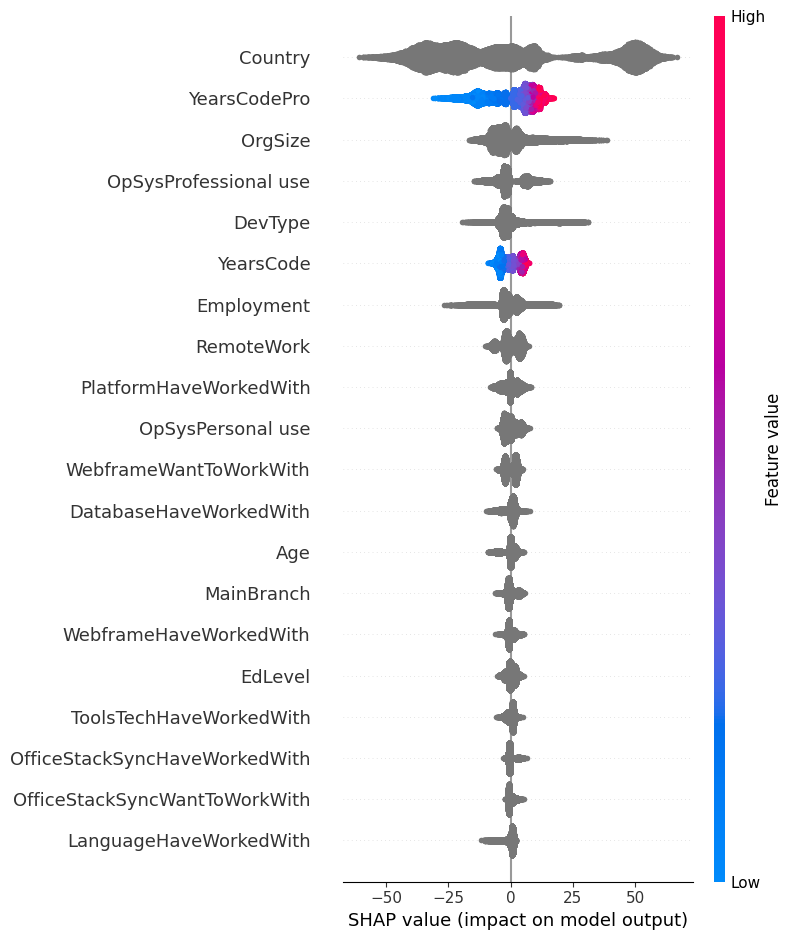

In [31]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)


In [33]:
expected_values = explainer.expected_value
print(f"Average predicted salary is {round(expected_values,1)} kUSD/year")
print(f"Average actual salary is {round(np.mean(y_test),1)} kUSD/year")

Average predicted salary is 87.9 kUSD/year
Average actual salary is 87.9 kUSD/year


In [34]:
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
import time

# Define parameter grid
param_grid = [
    {"iterations": 500, "depth": 6, "learning_rate": 0.1},
    {"iterations": 1000, "depth": 8, "learning_rate": 0.05},
    {"iterations": 2000, "depth": 10, "learning_rate": 0.02},
]

# Initialize pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# Track results
results = []

# Iterate over parameter combinations
for params in param_grid:
    start_time = time.time()

    # Initialize model with current parameters
    model = CatBoostRegressor(
        iterations=params["iterations"],
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        verbose=0,
        early_stopping_rounds=100,
        loss_function="RMSE",
    )

    # Train model
    model.fit(train_pool, eval_set=test_pool)

    # Make predictions
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)

    # Compute RMSE
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    # Record time taken and metrics
    elapsed_time = time.time() - start_time
    results.append({
        "params": params,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "time_taken": elapsed_time,
    })

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


                                              params  rmse_train  rmse_test  \
0  {'iterations': 500, 'depth': 6, 'learning_rate...   42.239015  43.709319   
1  {'iterations': 1000, 'depth': 8, 'learning_rat...   41.161296  43.543876   
2  {'iterations': 2000, 'depth': 10, 'learning_ra...   39.842566  43.504277   

    time_taken  
0   213.396025  
1   685.465863  
2  2440.508756  
